<a href="https://colab.research.google.com/github/David-GHMM/ML-Lab5/blob/main/%D0%9C%D0%9E_%D0%9B%D0%A05_%D0%9C%D0%B0%D1%80%D0%B3%D0%B0%D1%80%D1%8F%D0%BD_%D0%9F%D0%98%D0%9D_231.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Задание 5
# Кластеризация

**Цель работы:** научиться производить кластерный анализ данных с использованием метода К-средних.

Набор данных включает следующие атрибуты:
* **country** - страна-член ФИФА;
* **confederation** - конфедерация, к которой принадлежит страна;
* **population_share** - доля страны в мировом населении (в процентах);
* **tv_audience_share** - доля страны в мировой телеаудитории чемпионата мира (в процентах);
* **gdp_weighted_share** - доля аудитории страны, взвешенная по ВВП (в процентах).

---
# Часть первая

### 1. Импортируем библиотеки и загружаем данные

In [331]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('fifa_countries_audience.csv')
df.head()

,country,confederation,population_share,tv_audience_share,gdp_weighted_share
0,United States,CONCACAF,4.5,4.3,11.3
1,Japan,AFC,1.9,4.9,9.1
2,China,AFC,19.5,14.8,7.3
3,Germany,UEFA,1.2,2.9,6.3
4,Brazil,CONMEBOL,2.8,7.1,5.4


### 2. Получим информацию о датасете

In [332]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191 entries, 0 to 190
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   country             191 non-null    object 
 1   confederation       191 non-null    object 
 2   population_share    191 non-null    float64
 3   tv_audience_share   191 non-null    float64
 4   gdp_weighted_share  191 non-null    float64
dtypes: float64(3), object(2)
memory usage: 7.6+ KB


### 3. Проверяем данные на наличие пропущенных значений и выбросов

In [333]:
# проверяем на пропущенные значения
print(df.isnull().sum())

country               0
confederation         0
population_share      0
tv_audience_share     0
gdp_weighted_share    0
dtype: int64


### 4. Исключаем невлияющие категориальные признаки

In [334]:
df_copy_p1 = df.copy()

df_copy_p1.drop('country', axis=1, inplace = True)
df_copy_p1.drop('confederation', axis=1, inplace = True)

#для других частей лаб работы
df_copy_p2, df_copy_p3 = df_copy_p1.copy(), df_copy_p1.copy()

df_copy_p1.head()

,population_share,tv_audience_share,gdp_weighted_share
0,4.5,4.3,11.3
1,1.9,4.9,9.1
2,19.5,14.8,7.3
3,1.2,2.9,6.3
4,2.8,7.1,5.4


### 5. Применяем операцию нормализации для численной устойчивости

In [335]:
# импортируем класс для стандартизации данных
from sklearn.preprocessing import StandardScaler

# создадим объект класса StandardScaler
scaler = StandardScaler()
scaler

StandardScaler()

### 6. Приведем данные к единому масштабу

In [336]:
X = scaler.fit_transform(df_copy_p1)

X[:5]

array([[2.03431616, 2.61248647, 7.41489722],
       [0.70452623, 3.02750026, 5.90159409],
       [9.70618109, 9.87522782, 4.66343699],
       [0.34650587, 1.64412095, 3.97557193],
       [1.16483813, 4.5492175 , 3.35649337]])

### 7. Определяем оптимальное количество кластеров с помощью метода локтя

Главный вопрос, который решают на этапе обучения модели заключается в выборе количества кластеров. Количество кластеров в методе к-средних является так называемым **гиперпараметром**, т.е. параметром, который нужно задать до обучения модели. Сделаем вид, что не обладаем экспертными знаниями о количестве конфедераций (на самом деле известно, что их 6 - UEFA, AFC, CONMEBOL, CONCACAF, OFC, CAF). Значит нужно использовать **метод локтя**. Метод назван из-за формы получаемого графика. Если на графике отложены значения числа кластеров и внутрикластерной дисперсии, то график будет выглядеть как угловатая линия, которая резко падает до определённой точки, а затем продолжает снижаться, но уже не так сильно. Этот угол, напоминающий локоть, и является тем самым «локтем», который и ищут. Метод локтя позволяет найти баланс между погрешностью вычисляемой дисперсии и сложностью модели.

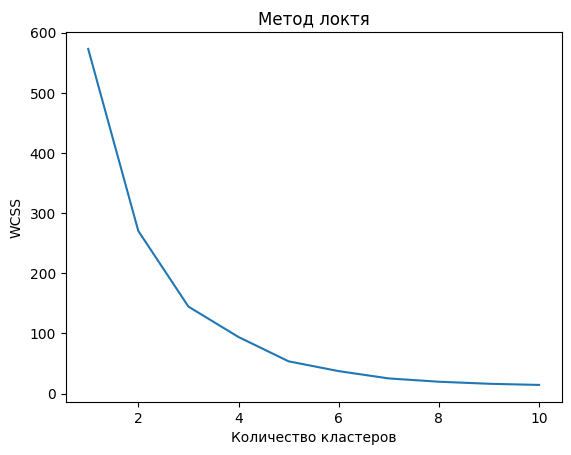

In [337]:
from sklearn.cluster import KMeans

wcss = []
for i in range(1, 11):
  kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
  kmeans.fit(X)
  wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('Метод локтя')
plt.xlabel('Количество кластеров')
plt.ylabel('WCSS')
plt.show()

По графику видно, что при переходе к 5+ кластерам, ошибка перестала существенно уменьшаться. Создадим объект класса модели, используя 6 кластеров в качестве гипепараметра модели. Стоит отметить, что полученное по графику количество (5 кластеров) не согласуется с исходным количеством кластеров в датасете (6), скорее всего, это объясняется тем, что близкие по параметрам друг к другу кластера можно объединить в один, что не даст существенной ошибки. (например, слияние конфедерафий Сев. и Южн. америк или Азиатской и Океании)

### 8. Обучаем модель кластеризации

In [338]:
# заново обучим модель с шестью кластерами
kmeans = KMeans(n_clusters=6, init='k-means++', max_iter=300, n_init=10, random_state=42)

# обучаем модель на стандартизированных данных
kmeans.fit(X)

KMeans(n_clusters=6, n_init=10, random_state=42)

### 9. Предсказываем кластеры и визуализируем результаты

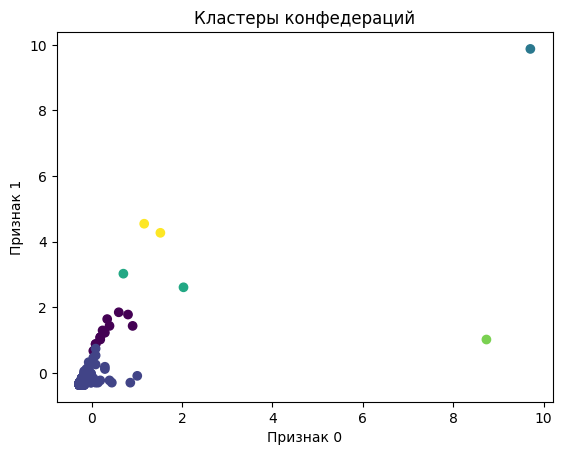

In [339]:
# предсказываем кластеры для каждого
labels = kmeans.predict(X)

# визуализируем результаты
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis')
plt.title('Кластеры конфедераций')
plt.xlabel('Признак 0')
plt.ylabel('Признак 1')
plt.show()

### 10. Интерпретируем результаты и улучшаем модель при необходимости

In [340]:
X[:5]

array([[2.03431616, 2.61248647, 7.41489722],
       [0.70452623, 3.02750026, 5.90159409],
       [9.70618109, 9.87522782, 4.66343699],
       [0.34650587, 1.64412095, 3.97557193],
       [1.16483813, 4.5492175 , 3.35649337]])

In [341]:
labels

array([3, 3, 2, 0, 5, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [342]:
df_copy_p1['Label'] = labels

df_copy_p1.head()

,population_share,tv_audience_share,gdp_weighted_share,Label
0,4.5,4.3,11.3,3
1,1.9,4.9,9.1,3
2,19.5,14.8,7.3,2
3,1.2,2.9,6.3,0
4,2.8,7.1,5.4,5


Можно легко проверить значения центроида, усреднив объекты в каждом кластере


In [343]:
df_copy_p1.groupby('Label').mean()

,population_share,tv_audience_share,gdp_weighted_share
Label,,,
0,1.184615,2.338462,2.861538
1,0.201163,0.172674,0.149419
2,19.500000,14.800000,7.300000
3,3.200000,4.600000,10.200000
4,17.600000,2.000000,0.500000
5,3.150000,6.900000,4.150000


Пример интерпретации:

* в кластеры 2 и 4 входят страны с самым большим количеством населения, но при этом во 2 кластере доля стран в мировой телеаудитории чемпионата мира и доля аудитории стран, взвешенная по ВВП имеют гораздо большие значения, чем в 4;

* в кластеры 0 и 1 входят страны с самым немногочисленным населением, что также отражается в невысоких результатах двух других метрик;

* кластеры 3 и 5 имеют "средние" значения метрик, но стоит отметить, что в 3 кластере доля аудитории стран, взвешенная по ВВП имеет самое большое значение среди всех кластеров, следовательно туда входят страны с не самым большим населением, но с хорошей и развитой экономикой.


В целом, по моему мнению, сложно "правильно" кластеризовать страны по конфедерациям, учитывая указанные метрики, т.к. чаще всего попадание страны в ту или иную конфедерацию зависит от географического положения страны или иногда от силы сборной (как в случае с переходом сборной Австралии из конфедерации Океании в Азиатскую, чтобы иметь более конкурентную среду).

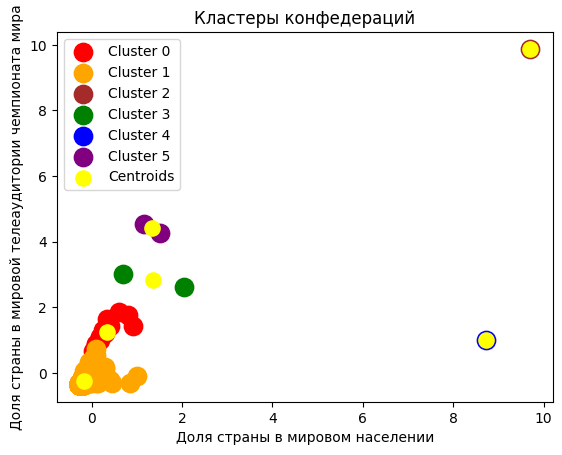

In [344]:
plt.scatter(X[labels == 0, 0], X[labels == 0, 1], s=175, c='red', label='Cluster 0')
plt.scatter(X[labels == 1, 0], X[labels == 1, 1], s=175, c='orange', label='Cluster 1')
plt.scatter(X[labels == 2, 0], X[labels == 2, 1], s=175, c='brown', label='Cluster 2')
plt.scatter(X[labels == 3, 0], X[labels == 3, 1], s=175, c='green', label='Cluster 3')
plt.scatter(X[labels == 4, 0], X[labels == 4, 1], s=175, c='blue', label='Cluster 4')
plt.scatter(X[labels == 5, 0], X[labels == 5, 1], s=175, c='purple', label='Cluster 5')

plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
            s=120, c='yellow', label='Centroids')

plt.title('Кластеры конфедераций')
plt.xlabel('Доля страны в мировом населении')
plt.ylabel('Доля страны в мировой телеаудитории чемпионата мира')
plt.legend()
plt.show()

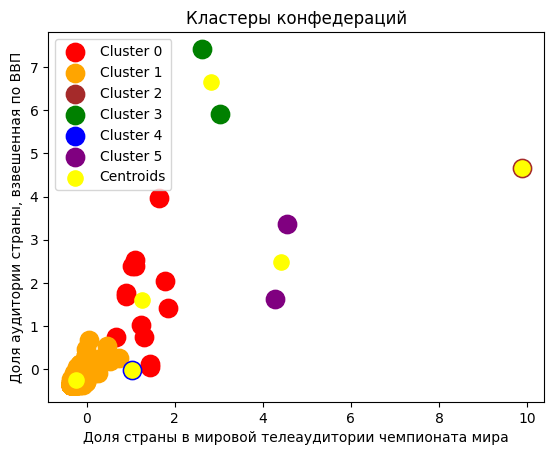

In [345]:
plt.scatter(X[labels == 0, 1], X[labels == 0, 2], s=175, c='red', label='Cluster 0')
plt.scatter(X[labels == 1, 1], X[labels == 1, 2], s=175, c='orange', label='Cluster 1')
plt.scatter(X[labels == 2, 1], X[labels == 2, 2], s=175, c='brown', label='Cluster 2')
plt.scatter(X[labels == 3, 1], X[labels == 3, 2], s=175, c='green', label='Cluster 3')
plt.scatter(X[labels == 4, 1], X[labels == 4, 2], s=175, c='blue', label='Cluster 4')
plt.scatter(X[labels == 5, 1], X[labels == 5, 2], s=175, c='purple', label='Cluster 5')

plt.scatter(kmeans.cluster_centers_[:, 1], kmeans.cluster_centers_[:, 2],
            s=120, c='yellow', label='Centroids')

plt.title('Кластеры конфедераций')
plt.xlabel('Доля страны в мировой телеаудитории чемпионата мира')
plt.ylabel('Доля аудитории страны, взвешенная по ВВП')
plt.legend()
plt.show()


---
# Часть вторая

Первые 8 пунктов повторяются из предыдущей части

### 9. Предсказываем кластеры и визуализируем результаты

In [346]:
# предсказываем кластеры для каждого
clusters = kmeans.predict(X)

# Добавляем метки кластеров в исходные данные
df_copy_p2['cluster'] = clusters
df_copy_p2.head()

,population_share,tv_audience_share,gdp_weighted_share,cluster
0,4.5,4.3,11.3,3
1,1.9,4.9,9.1,3
2,19.5,14.8,7.3,2
3,1.2,2.9,6.3,0
4,2.8,7.1,5.4,5


### 10. Визуализация результатов

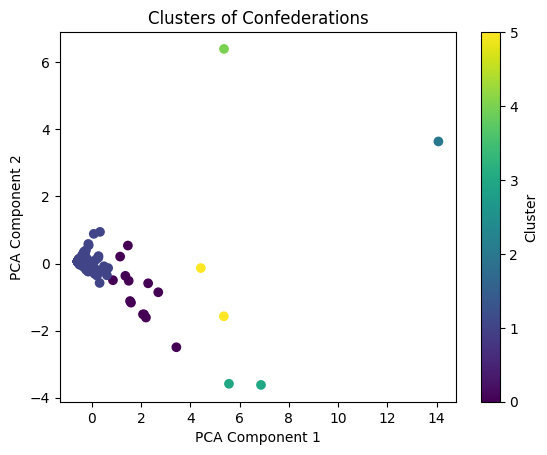

In [347]:
from sklearn.decomposition import PCA

# Уменьшаем размерность до 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Визуализация
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Clusters of Confederations')
plt.colorbar(label='Cluster')
plt.show()

Группируем по кластерам и анализируем средние значения в каждом кластере

In [348]:
# Группируем по кластерам
cluster_groups = df_copy_p2.groupby('cluster')

# Анализ средних значений в каждом кластере
cluster_groups.mean()

,population_share,tv_audience_share,gdp_weighted_share
cluster,,,
0,1.184615,2.338462,2.861538
1,0.201163,0.172674,0.149419
2,19.500000,14.800000,7.300000
3,3.200000,4.600000,10.200000
4,17.600000,2.000000,0.500000
5,3.150000,6.900000,4.150000


Средние значения для каждого кластера полученные в данной части полностью совпадают с полученными в 1 части.

---
# Часть третья

Первые 8 пунктов повторяются из предыдущей части

### 9. Предсказываем кластеры и визуализируем результаты

In [349]:
# предсказываем кластеры для каждого
clusters = kmeans.predict(X)

# Добавляем метки кластеров в исходные данные
df_copy_p3['cluster'] = clusters
df_copy_p3.head()

,population_share,tv_audience_share,gdp_weighted_share,cluster
0,4.5,4.3,11.3,3
1,1.9,4.9,9.1,3
2,19.5,14.8,7.3,2
3,1.2,2.9,6.3,0
4,2.8,7.1,5.4,5


### 10. Визуализация результатов

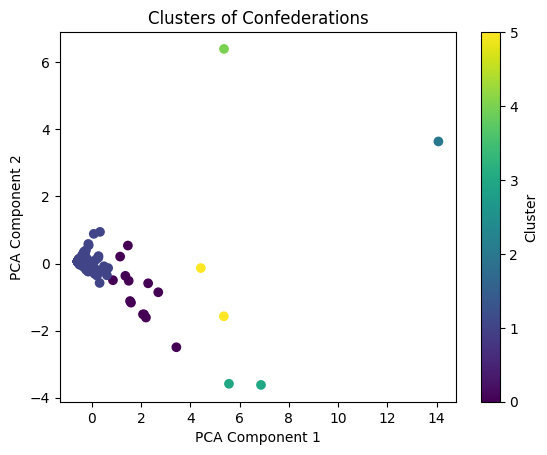

In [350]:
from sklearn.decomposition import PCA

# Уменьшаем размерность до 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Визуализация
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Clusters of Confederations')
plt.colorbar(label='Cluster')
plt.show()

Группируем по кластерам и анализируем средние значения в каждом кластере

In [351]:
# Группируем по кластерам
cluster_groups = df_copy_p3.groupby('cluster')

# Анализ средних значений в каждом кластере
cluster_groups.mean()

,population_share,tv_audience_share,gdp_weighted_share
cluster,,,
0,1.184615,2.338462,2.861538
1,0.201163,0.172674,0.149419
2,19.500000,14.800000,7.300000
3,3.200000,4.600000,10.200000
4,17.600000,2.000000,0.500000
5,3.150000,6.900000,4.150000


Средние значения для каждого кластера полученные в данной части полностью совпадают с полученными в 1 и 2 частях.

In [352]:
# Добавляем названия стран в исходные данные
df_copy_p3['country'] = df['country']
df_copy_p3.head()

,population_share,tv_audience_share,gdp_weighted_share,cluster,country
0,4.5,4.3,11.3,3,United States
1,1.9,4.9,9.1,3,Japan
2,19.5,14.8,7.3,2,China
3,1.2,2.9,6.3,0,Germany
4,2.8,7.1,5.4,5,Brazil


In [353]:
# Вывод стран в каждом кластере
for cluster_num in range(5):
  print(f'\nCluster "Confederation {cluster_num}":')
  print(df_copy_p3[df_copy_p3['cluster'] == cluster_num]['country'].values)


Cluster "Confederation 0":
['Germany' 'United Kingdom' 'Italy' 'France' 'Russia' 'Spain'
 'South Korea' 'Mexico' 'Turkey' 'Thailand' 'Argentina' 'Nigeria'
 'Vietnam']

Cluster "Confederation 1":
['Netherlands' 'Poland' 'Saudi Arabia' 'Taiwan' 'Canada' 'Colombia'
 'Venezuela' 'South Africa' 'Malaysia' 'Switzerland' 'Belgium' 'Sweden'
 'Iran' 'Chile' 'Romania' 'Austria' 'Singapore' 'Australia' 'Greece'
 'Portugal' 'Czech Republic' 'Egypt' 'Denmark' 'Norway' 'Peru' 'Ukraine'
 'Iraq' 'Hungary' 'Kazakhstan' 'Finland' 'Ireland' 'Algeria' 'Cuba'
 'Ecuador' 'Slovakia' 'Qatar' 'Kuwait' 'Bulgaria' 'Serbia' 'Belarus'
 'Hong Kong' 'Croatia' 'Oman' 'Dominica Republic' 'Azerbaijan'
 'New Zealand' 'Lithuania' 'Slovenia' 'Uruguay' 'Costa Rica' 'Uzbekistan'
 'Yemen' 'Israel' 'El Salvador' 'Syria' 'Pakistan' 'Guatemala' 'Paraguay'
 'Panama' 'Bosnia-Herzegovina' 'Cambodia' 'Ivory Coast' 'Macau' 'Latvia'
 'Lebanon' 'Jordan' 'Honduras' 'Brunei' 'Albania' 'Turkmenistan' 'Angola'
 'Estonia' 'Bahrain' 'Nepal